# FastAI XLA Extensions Library

> The FastAI XLA Extensions library package allows your fastai/Pytorch models to run on TPUs using the Pytorch-XLA library.

## Install

`pip install git+https://github.com/butchland/fastai_xla_extensions`

## How to use

### Configure the Pytorch XLA package 

The Pytorch xla package requires an environment supporting TPUs (Kaggle kernels, GCP or Colab environments required)

If running on Colab, make sure the Runtime Type is set to TPU.


In [ ]:
#hide
#colab
IN_COLAB = True

In [ ]:
#hide
#colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    IN_COLAB = False

Mounted at /content/drive


In [ ]:
#hide
#colab
import os
if IN_COLAB:
    assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
#hide
#colab
![ -d /content ] && [ ! -d /content/data ] && curl -s https://course19.fast.ai/setup/colab | bash 

Updating fastai...
Done.


## Install fastai

Use latest fastai and fastcore versions

In [ ]:
#hide_output
#colab
![ -d /content ] && pip install -Uqq fastcore --upgrade
![ -d /content ] && pip install -Uqq fastai --upgrade

## Setup torch XLA


This is the official way to install Pytorch-XLA 1.7 [instructions here](https://colab.research.google.com/github/pytorch/xla/blob/master/contrib/colab/getting-started.ipynb#scrollTo=CHzziBW5AoZH)

In [ ]:
#hide_output
#colab
![ -d /content ] && pip install -Uqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 133.6MB 76kB/s 
     |████████████████████████████████| 61kB 3.7MB/s 


In [ ]:
#hide
#colab
# use this for getting pytorch XLA nightly version
# VERSION = "20200707"  #@param ["1.5" , "20200325","20200707", "nightly"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION

In [ ]:
#hide
!pip freeze | grep torch
!pip freeze | grep fast

torch==1.7.0+cu101
torch-xla==1.7
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.1+cu101
fastai==2.1.8
fastcore==1.3.11
fastdtw==0.3.4
fastprogress==1.0.0
fastrlock==0.5


In [ ]:
#hide
#colab
%cd /content/drive/MyDrive/fastai_xla_extensions

/content/drive/MyDrive/fastai_xla_extensions


## Check if XLA is available

In [ ]:
#hide
DEBUG = False # set to false for prod release
TRACE = False # set to false for prod release

In [ ]:
#hide
if DEBUG:
    from pdb import set_trace
else:
    from fastcore.imports import noop
    set_trace = noop

In [ ]:
#hide
#colab
import warnings
try:
    import torch_xla
except ImportError as e:
    if DEBUG: warnings.warn('TPU environment not available')
    

In [ ]:
#hide
#colab
%cd /content/drive/MyDrive/fastai_xla_extensions/
import fastai_xla_extensions.core

/content/drive/MyDrive/fastai_xla_extensions


In [ ]:
#hide
#local
%cd ..
import fastai_xla_extensions.core


### Import the libraries
Import the fastai and fastai_xla_extensions libraries

In [ ]:
#colab
#hide_output
import fastai_xla_extensions.core

In [ ]:
from fastai.vision.all import *

### Example
Build a MNIST classifier -- adapted from fastai course [Lesson 4 notebook](https://github.com/fastai/course-v4/blob/master/nbs/04_mnist_basics.ipynb)

In [ ]:
#hide
#local
%cd nbs

In [ ]:
#hide
#colab
%cd /content

/content


Load MNIST dataset 

In [ ]:
path = untar_data(URLs.MNIST_TINY)

In [ ]:
#hide
Path.BASE_PATH = path

Create Fastai DataBlock


_Note that batch transforms are currently
set to none as they seem to slow the training
on the TPU (for investigation)._

In [ ]:
datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(),
    get_y=parent_label,
    item_tfms=Resize(28),
    batch_tfms=[]
)

In [ ]:
#colab
datablock.summary(path)

Setting-up type transforms pipelines
Found 1428 items
2 datasets of sizes 709,699
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_tiny/train/3/9612.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/mnist_tiny/train/3/9612.png
    applying parent_label gives
      3
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(0))


Found 1428 items
2 datasets of sizes 709,699
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: Resize -- {'s

Create the dataloader

In [ ]:
dls = datablock.dataloaders(path)

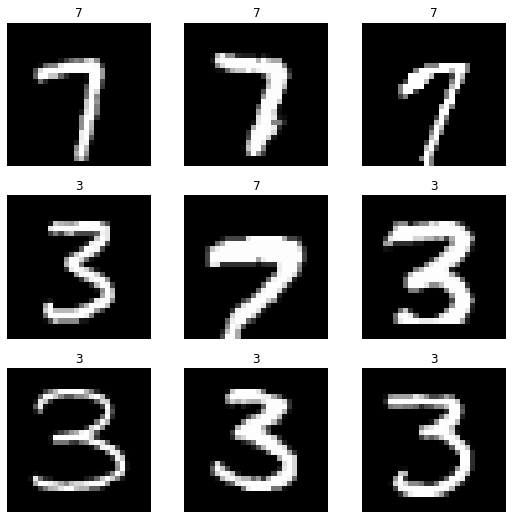

In [ ]:
#colab
dls.show_batch()

Create a Fastai CNN Learner


In [ ]:
#colab
learner = cnn_learner(dls, resnet18, metrics=accuracy)
                      

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
#colab
learner.unfreeze()

In [ ]:
#colab
learner.summary()

Sequential (Input shape: ['64 x 3 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 14 x 14    9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 14 x 14    128        True      
________________________________________________________________
ReLU                 64 x 64 x 14 x 14    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 7 x 7      0          False     
________________________________________________________________
Conv2d               64 x 64 x 7 x 7      36,864     True      
________________________________________________________________
BatchNorm2d          64 x 64 x 7 x 7      128        True      
________________________________________________________________
ReLU                 64 x 64 x 7 x 7      0          False     
___________________________________________________

Using the `lr_find` works 

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=6.309573450380412e-07)

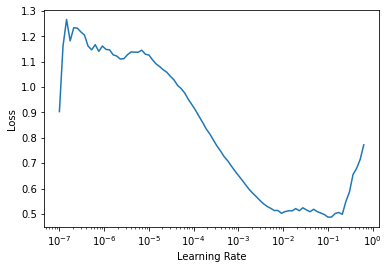

In [ ]:
#colab
learner.lr_find()

Run one cycle training.


In [ ]:
#colab
learner.fit_one_cycle(5,lr_max=slice(6.3e-07,0.01))

epoch,train_loss,valid_loss,accuracy,time
0,0.629290,1.190237,0.566524,00:10
1,0.358590,0.232812,0.911302,00:02
2,0.237743,0.130314,0.971388,00:02
3,0.169761,0.126199,0.969957,00:02
4,0.122370,0.111455,0.971388,00:02


Further fine-tuning

In [ ]:
#colab
learner.fit_one_cycle(5,slice(7e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.005863,0.070885,0.984263,00:02
1,0.038074,0.360497,0.948498,00:02
2,0.109056,0.150170,0.979971,00:02
3,0.114290,0.122179,0.984263,00:02
4,0.087704,0.071846,0.989986,00:02


In [ ]:
#hide
#colab
learner.save('stage-1')

Path('models/stage-1.pth')

In [ ]:
#hide
#colab
learner.load('stage-1')

Model params are using TPU

In [ ]:
#colab
one_param(learner.model).device

device(type='xla', index=1)

Plot loss seems to be working fine.

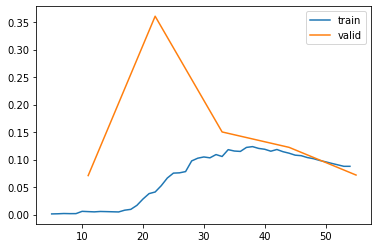

In [ ]:
#colab
learner.recorder.plot_loss()

## Samples

Other examples of fastai notebooks using the fastai_xla_extensions package are also available here: 

* [Vision](https://github.com/butchland/fastai_xla_extensions/blob/master/samples/MNIST_TPU_demo.ipynb) [![](https://camo.githubusercontent.com/52feade06f2fecbf006889a904d221e6a730c194/68747470733a2f2f636f6c61622e72657365617263682e676f6f676c652e636f6d2f6173736574732f636f6c61622d62616467652e737667)](https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/samples/MNIST_TPU_demo.ipynb)

* [Collaborative Filtering](https://github.com/butchland/fastai_xla_extensions/blob/master/samples/MovieLensCollaborativeFilteringTPU.ipynb) [![](https://camo.githubusercontent.com/52feade06f2fecbf006889a904d221e6a730c194/68747470733a2f2f636f6c61622e72657365617263682e676f6f676c652e636f6d2f6173736574732f636f6c61622d62616467652e737667)](https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/samples/MovieLensCollaborativeFilteringTPU.ipynb)

* [Tabular](https://github.com/butchland/fastai_xla_extensions/blob/master/samples/TabularTrainingTPUdemo.ipynb) [![](https://camo.githubusercontent.com/52feade06f2fecbf006889a904d221e6a730c194/68747470733a2f2f636f6c61622e72657365617263682e676f6f676c652e636f6d2f6173736574732f636f6c61622d62616467652e737667)](https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/samples/TabularTrainingTPUdemo.ipynb)

More samples will be added in the future as we fix issues and implement more capabilities.


## Status
The fastai XLA extensions library is still in very early development phase (not even alpha) which means there's still a lot of things not working. 

Use it at your own risk.

If you wish to contribute to the project, fork it and make pull request. 

This project uses [nbdev](https://nbdev.fast.ai/) -- a jupyter notebook first development environment and is being developed on [Colab](https://colab.research.google.com).
